In [1]:
# this notebook processes data and simulations for figure 3 and makes figure 3
import os, torch, lyapun, fig3
import numpy as np 
from matplotlib import pyplot as plt
import matplotlib as mpl 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# import the table of experiments, should be 10 experiments. 
db = lyapun.getdb()
db

[{'mname': 'FX26'},
 {'mname': 'FX14'},
 {'mname': 'FX17'},
 {'mname': 'FX42'},
 {'mname': 'FX43'},
 {'mname': 'QZ2'},
 {'mname': 'GP9'},
 {'mname': 'GP7'},
 {'mname': 'GP10'},
 {'mname': 'GP8'}]

In [2]:
# replaces this with your own path to the data (~10GB/file)
root = r'/media/carsen/ssd3/random_matrix/'

evals = []

for iexp in range(len(db)):
    fname = os.path.join(root, 'F_%s.npz'%db[iexp]['mname'])
    print(fname)

    # this data has already been deconvolved as described in the paper
    dat = np.load(fname, allow_pickle = False)    
    sp, xpos, ypos, snr = dat['sp'], dat['xpos'], dat['ypos'], dat['snr']

    # keep only neurons with fluorescence snr at least 0.3
    sp   = sp[snr>.3]
    xpos = xpos[snr>.3]
    ypos = ypos[snr>.3]

    # normalize the data
    sp = lyapun.zscore(sp, axis=1)
    
    # use dynamic mode decomposition to estimate complex eigenvalues
    e   = lyapun.dmd(    sp, lam = .01, delta = 5,device = device)

    # compute the autocorrelation time scales
    acg = lyapun.pc_timescales(sp, xpos, ypos, device = device)

    evals.append({'e': e, 'acg':acg })  

/media/carsen/ssd3/random_matrix/F_FX26.npz
/media/carsen/ssd3/random_matrix/F_FX14.npz
/media/carsen/ssd3/random_matrix/F_FX17.npz
/media/carsen/ssd3/random_matrix/F_FX42.npz
/media/carsen/ssd3/random_matrix/F_FX43.npz
/media/carsen/ssd3/random_matrix/F_QZ2.npz
/media/carsen/ssd3/random_matrix/F_GP9.npz
/media/carsen/ssd3/random_matrix/F_GP7.npz
/media/carsen/ssd3/random_matrix/F_GP10.npz
/media/carsen/ssd3/random_matrix/F_GP8.npz


In [3]:
# the simulations use 5,000 neuron by default
N = 5000

for k in range(8):
    # we produce 4 symmetric and 4 non-symmetric simulations
    if k<4:
        symm = True 
    else:
        symm = False 
    
    # obtain a random matrix A
    A =  lyapun.getA(N, symm = symm, device = device)
    
    # normalize A to a maximum eigenvalue of 0.99
    A = lyapun.Aregularize(A, symm = symm)
    
    # simulate the system with a step size of 5ms and timescale of 50ms
    Xt = lyapun.simulateA(A, dt = 5, tau = 50, device = device)
       
    sp = Xt.cpu().numpy()

    # Generate random positions in the range 0-1000 "um". 
    # These are necessary for neuron splits into train/test like we do for the real data.
    xpos = 1000 * np.random.rand(N,)
    ypos = 1000 * np.random.rand(N,)

    # run the same analyses as for the real data
    e   = lyapun.dmd(    sp, lam = .01, delta = 5, device = device)
    acg = lyapun.pc_timescales(sp, xpos, ypos, device = device)
    evals.append({'eA': e, 'acg':acg })

evals2 = evals.copy()



100%|██████████| 24000/24000 [00:10<00:00, 2197.04it/s]


In [4]:
mname = ['Waksman', 'Robbins', 'Krebs']

for jj in range(len(mname)):
    dat = np.load(os.path.join(root, '%s_spks_face.npz'%mname[jj]), allow_pickle = True)
    sp, xpos, ypos = lyapun.ephys_load(dat)

    # normalize like above
    spz = lyapun.zscore(sp, axis=-1)

    # run the same analyses as above 
    e   = lyapun.dmd(spz, lam = .1, delta = 5, device = device)

    # sig = 2 is the default for the ephys data due to high noise (see paper)
    acg = lyapun.pc_timescales(spz, xpos, ypos, sig = 2, device = device)

    evals.append({'eA': e, 'acg':acg })

In [5]:
# save the results so the figure can be remade easily
os.makedirs('../results', exist_ok=True)
np.savez('../results/evals21_final.npz', 
         evals=np.array(evals, dtype=object))

In [6]:
# reload the results from disk if necessary
evals = np.load('../results/evals21_final.npz', 
                allow_pickle=True)['evals']
evals = list(evals)

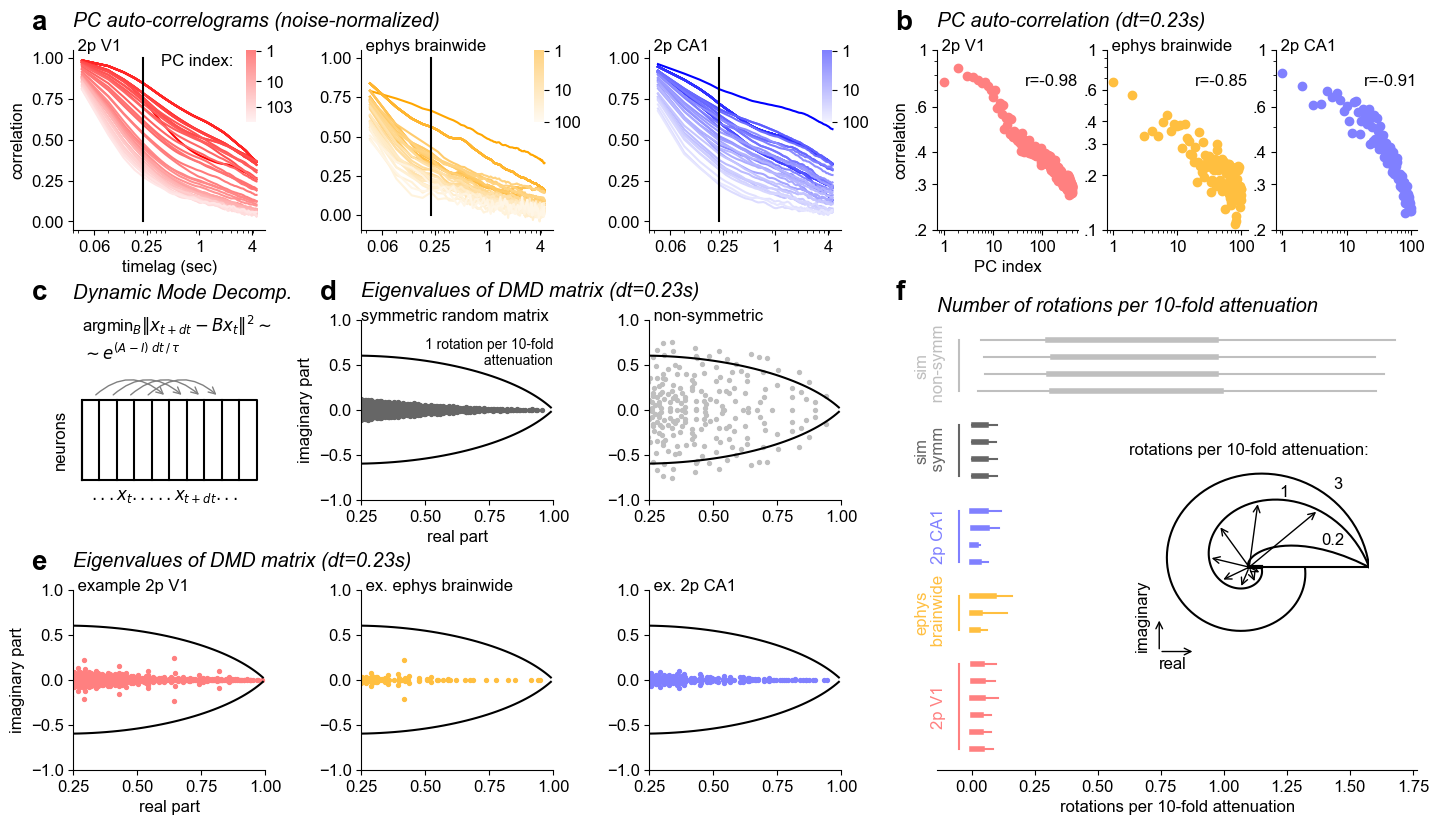

In [7]:
mpl.rcParams['font.family'] = 'Arial' 

fig = plt.figure(figsize=(14,7.5))

dcolors = [[.5,0,0], [.5,.5,0], [0,0,.5], [.75, .75, .75], [.5, .5, .5]]
grid = plt.GridSpec(3,5, figure=fig, left=0.02, right=0.98, top=0.98, bottom=0.02, 
                    wspace = 0.5, hspace = 0.5)
il = 0

il = fig3.fig00(fig, il, grid, evals)
il = fig3.fig02(fig, il, grid, evals)
il = fig3.fig10(fig, il, grid, evals)
il = fig3.fig11(fig, il, grid, evals)
il = fig3.fig20(fig, il, grid, evals)
il = fig3.fig23(fig, il, grid, evals)

#fig.savefig("fig3.pdf", dpi=300, bbox_inches = 'tight')